# Clinical application of connectome kernel normative models

---

Using the connectome spectral normative models developed in notebooks in chapter 5, we now turn our attention to applying the pretrained spectral model to a clinical sample to extract interesting knowledge about how pathological brain changes are linked to behaviors.

Note: this notebook is executed on CSC servers...

## Notebook 7.1.1: MACC Data Preparation

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
from sklearn import metrics


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = "/home/sina/storage"
gitrepo_dir = f"{main_dir}/Normative_Modeling/git-repo/normative_brain_charts"
# clone of https://github.com/Washington-University/HCPpipelines
hcp_pipeline_dir = f"{main_dir}/HCPpipelines"
# clone of https://github.com/edickie/ciftify
ciftify_dir = f"{main_dir}/ciftify"


### Brain visualization functions

---

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']


In [6]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{hcp_pipeline_dir}/global/templates/91282_Greyordinates/91282_Greyordinates.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
# left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface_file = f'{ciftify_dir}/ciftify/data/HCP_S1200_GroupAvg_v1/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{ciftify_dir}/ciftify/data/HCP_S1200_GroupAvg_v1/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


#### Faster brain visualization by Cerebro

---

In [7]:
# Cerebro brain viewer used for visualization
from cerebro import cerebro_brain_utils as cbu
from cerebro import cerebro_brain_viewer as cbv


In [8]:
# Brain visualizations with Cerebro

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

def plot_single_view_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, vlims=None, exclusion_color=(1.,1.,1.,0), view="L", show_colorbar=False, colorbar_format=None, cifti_left_right_seperation=0, surface = 'midthickness'):
    try:
        
        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=(1., 1., 1., 0.0), no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none', cifti_left_right_seperation=cifti_left_right_seperation,
        )

        dscalar_layer = my_brain_viewer.add_cifti_dscalar_layer(
            dscalar_data=dscalar_data,
            colormap=colormap,
            clims=clims,
            vlims=vlims,
            exclusion_color=exclusion_color,
            opacity=0.95)

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

def plot_left_right_surface_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, show_colorbar=False, colorbar_format=None, **kwargs):
    # Hide the parent axis
    ax.set_visible(False)

    # Create a 2x2 GridSpec within the axis using inset_axes
    gs = ax.inset_axes([0, 0, 1, 1], transform=ax.transAxes)
    sub_gs = GridSpec(2, 2, gs, hspace=0., wspace=0.)

    # Create a 4x4 grid
    ax_tl = fig.add_subplot(sub_gs[0, 0])
    ax_tr = fig.add_subplot(sub_gs[0, 1])
    ax_bl = fig.add_subplot(sub_gs[1, 0])
    ax_br = fig.add_subplot(sub_gs[1, 1])
    
    # separate data to left and right
    dscalar_data_left = dscalar_data.copy()
    dscalar_data_left[left_cortical_surface_model.index_count:] = np.nan
    dscalar_data_right = dscalar_data.copy()
    dscalar_data_right[:left_cortical_surface_model.index_count] = np.nan
    
    # Lateral left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_tl, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), **kwargs)
    # Medial left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_bl, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)
    
    # Lateral right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_tr, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), **kwargs)
    # Medial right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_br, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)

    if show_colorbar:
        cax = inset_axes(
            ax,
            width="30%",
            height="4%",
            loc="center",
            bbox_to_anchor=(-0., 0.0, 1., 1.),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        cb = fig.colorbar(
            mpl.cm.ScalarMappable(
                norm=mpl.colors.Normalize(vmin=clims[0], vmax=clims[1]),
                cmap=colormap
            ),
            cax=cax,
            aspect=10,
            orientation='horizontal',
            format=colorbar_format,
        )
        cb.outline.set_visible(False)
        cb.ax.tick_params(labelsize=12)
        cb.ax.tick_params(length=0)


## Load the connectome kernel

---

In [9]:
# store the computed kernel
connectome_kernel_eigenvalues = load_np(f'{main_dir}/Normative_Modeling/data/npy/rw_cortical_connectome_eigenvalues_cifti.npy');
connectome_kernel_eigenvectors = load_np(f'{main_dir}/Normative_Modeling/data/npy/rw_cortical_connectome_eigenvectors_cifti.npy');


In [110]:
connectome_kernel_eigenvalues.shape, connectome_kernel_eigenvectors.shape

((11001,), (59412, 11001))

## Create a fixed BSpline function to ensure consistent nonlinear expansions of age across all models

---



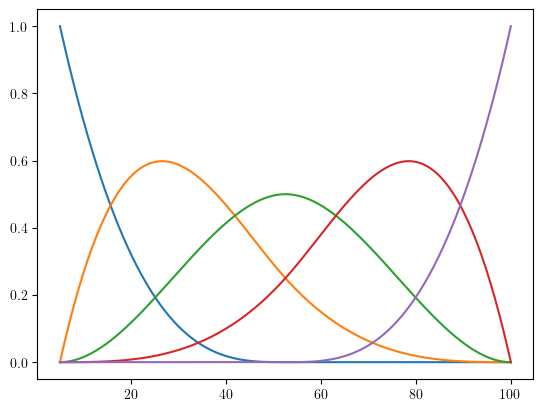

In [10]:
# fixed B-spline
age_min=5
age_max=100
num_knots = 3
patsy_knots = np.linspace(age_min, age_max, num_knots)[1:-1]
fixed_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": (np.linspace(age_min, age_max, 200)), "knots": patsy_knots},
)
plt.plot(np.linspace(age_min, age_max, 200), fixed_B_spline_age)



## Load selected covariance pairs

---

The largest pairs of kernels in terms of correlation are stored to model a sparse covariance structure.


In [11]:
corr_max_all = load_np(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_rho_corr_max_all.npy')
selected_pairs = load_np(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_rho_selected_pairs_rho.npy')


In [12]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]


In [13]:
len(selected_pairs)

4261

In [14]:
len(rows_lim)

4261

In [15]:
%%time
sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(selected_pairs.max() + 1, selected_pairs.max() + 1)
)


CPU times: user 596 μs, sys: 1.67 ms, total: 2.26 ms
Wall time: 1.73 ms


## Load fitted kernel normative models

---


In [19]:
%%time
kernel_posterior_means = xr.open_dataset(f'{main_dir}/Normative_Modeling/data/models/pymc/combined_connectome_rw_kernel_posterior_means_pymc_advi.nc',)
kernel_posterior_means


CPU times: user 192 ms, sys: 72.1 ms, total: 264 ms
Wall time: 1.8 s


<xarray.Dataset> Size: 2MB
Dimensions:                (kernel: 10000, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                    (sex) float64 16B 1.0 0.0
  * site                   (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel
Data variables:
    mu_intercept_site      (kernel) float64 80kB ...
    intercept_sex          (kernel, sex) float64 160kB ...
    intercept_site_offset  (kernel, site) float64 240kB ...
    w_age                  (kernel, splines) float64 400kB ...
    sigma_intercept_site   (kernel) float64 80kB ...
    sigma_error_site       (kernel) float64 80kB ...
    w_error_age            (kernel, splines) float64 400kB ...
    error_sex              (kernel, sex) float64 160kB ...
    error_site_offset      (kernel, site) float64 240kB ...
    intercept_site         (kernel, site) float64 240kB ...
    error_site             (kernel, site) float64 240kB ...

In [20]:
%%time
rho_kernel_posterior_means = xr.open_dataset(f'{main_dir}/Normative_Modeling/data/models/pymc/combined_connectome_rw_rho_kernel_posterior_means_pymc_advi.nc')
rho_kernel_posterior_means


CPU times: user 55.1 ms, sys: 4.41 ms, total: 59.5 ms
Wall time: 83.5 ms


<xarray.Dataset> Size: 512kB
Dimensions:                    (kernel_pair: 4261, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                        (sex) float64 16B 1.0 0.0
  * site                       (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-si...
  * splines                    (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair) float64 34kB ...
    intercept_sex_rho          (kernel_pair, sex) float64 68kB ...
    intercept_site_offset_rho  (kernel_pair, site) float64 102kB ...
    w_age_rho                  (kernel_pair, splines) float64 170kB ...
    sigma_intercept_site_rho   (kernel_pair) float64 34kB ...
    intercept_site_rho         (kernel_pair, site) float64 102kB ...

### Also Load observed training moments (mean and sigma used for standardization)

---


In [22]:
%%time
kernel_means = np.load(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_kernel_means.npy').tolist()
kernel_stds = np.load(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_kernel_stds.npy').tolist()


CPU times: user 4.51 ms, sys: 1.75 ms, total: 6.26 ms
Wall time: 11.5 ms


In [112]:
len(kernel_means), len(kernel_stds)

(10000, 10000)

## Load all MACC data

---

### Load MACC high-resolution thickness data

---

In [16]:
all_thickness_data_MACC = load_np(f'{main_dir}/Normative_Modeling/data/MACC/summary/all_thickness_data_MACC.npy');
all_thickness_data_MACC.shape


(679, 59412)

In [17]:
connectome_kernel_eigenvectors.shape

(59412, 11001)

In [18]:
# center the data prior to encoding
all_thickness_data_MACC_encoded = np.dot(all_thickness_data_MACC, connectome_kernel_eigenvectors)
all_thickness_data_MACC_encoded.shape


(679, 11001)

In [23]:
valid_subjects = load_json("/mnt/isilon/CSC1/Yeolab/Users/sina/Normative_Modeling/data/MACC/summary/valid_subjects.json");


In [25]:
len(valid_subjects)

679

## Load demography data

---

In [26]:
# demography data collated by Hongwei
summary_df = pd.read_csv("/mnt/isilon/CSC2/Yeolab/Data/UKBioBank/user_data/hyan/normative_modeling/ALL_dataset/model_fitting01/surface_reconstruction_Yan1000/summary/MACC.csv")


In [78]:
selected_columns = ['sex', "scan_age", "subject_id", "diagnosis", "mmse"]
demography_df_MACC = summary_df[summary_df["visit_code"] == "BL"][selected_columns].copy()
demography_df_MACC = demography_df_MACC.rename(columns={"scan_age":"age", "subject_id": "subject_ID"})
demography_df_MACC = demography_df_MACC[demography_df_MACC["subject_ID"].isin(valid_subjects)]


In [79]:
# drop NAs
real_valid_subjects = list(demography_df_MACC[~demography_df_MACC.isna().any(axis=1)]["subject_ID"])
valid_subject_mask = [x in real_valid_subjects for x in valid_subjects]
demography_df_MACC[~demography_df_MACC.isna().any(axis=1)]
demography_df_MACC = demography_df_MACC.set_index('subject_ID').reindex(real_valid_subjects).reset_index()
demography_df_MACC["sex"] = demography_df_MACC["sex"].replace({'M': 0, 'F': 1}).astype(int)
demography_df_MACC


/tmp/ipykernel_149116/160339493.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  demography_df_MACC["sex"] = demography_df_MACC["sex"].replace({'M': 0, 'F': 1}).astype(int)


,subject_ID,sex,age,diagnosis,mmse
0,HD001,0,58.000000,NCI,26.0
1,HD002,1,63.000000,NCI,30.0
2,HD003,1,87.000000,AD,17.0
3,HD004,0,72.000000,VCIND,27.0
4,HD005,0,64.000000,VAD,14.0
...,...,...,...,...,...
669,HD708,1,68.000000,CIND,25.0
670,HD709,0,73.394521,NCI,28.0
671,HD710,1,73.421918,CIND,29.0
672,HD711,1,61.331507,NCI,30.0


In [81]:
# filter previous data by real valid entries
all_thickness_data_MACC = all_thickness_data_MACC[valid_subject_mask]
all_thickness_data_MACC_encoded = all_thickness_data_MACC_encoded[valid_subject_mask]


In [84]:
# reduce number of required kernels to increase efficiency
N_kernel = 1000

demography_extended_df_MACC = pd.concat(
    [
        demography_df_MACC,
        pd.DataFrame(
            all_thickness_data_MACC_encoded[:,:N_kernel],
            columns=[f'thickness_connectome_pc_{i}' for i in range(N_kernel)],
        ),
    ],
    axis=1,
)

demography_extended_df_MACC.head()


,subject_ID,sex,age,diagnosis,mmse,thickness_connectome_pc_0,thickness_connectome_pc_1,thickness_connectome_pc_2,thickness_connectome_pc_3,thickness_connectome_pc_4,...,thickness_connectome_pc_990,thickness_connectome_pc_991,thickness_connectome_pc_992,thickness_connectome_pc_993,thickness_connectome_pc_994,thickness_connectome_pc_995,thickness_connectome_pc_996,thickness_connectome_pc_997,thickness_connectome_pc_998,thickness_connectome_pc_999
0,HD001,0,58.0,NCI,26.0,595.404921,-2.988673,28.387228,-47.514605,14.128553,...,-0.548404,1.004921,2.305832,2.339347,-1.838847,-1.355246,0.406034,1.422772,1.133603,-3.565102
1,HD002,1,63.0,NCI,30.0,578.305361,4.541116,17.579084,-56.689357,15.704129,...,-1.734315,0.247441,0.006548,-0.752449,1.522519,-0.164277,2.750056,0.936918,-1.015317,0.239366
2,HD003,1,87.0,AD,17.0,583.584819,-3.577608,21.320147,-29.771606,3.478685,...,0.493210,-1.526711,-0.513072,-0.878510,1.467293,-0.041904,4.759097,-0.118015,-1.831489,1.210456
3,HD004,0,72.0,VCIND,27.0,569.606960,17.875988,33.168828,-21.237119,19.472234,...,1.344747,0.439367,2.489475,-0.491276,-4.140618,0.997443,2.554370,-0.693051,-1.779164,-3.283816
4,HD005,0,64.0,VAD,14.0,553.304157,-0.889549,18.389647,-31.733231,4.780241,...,0.660276,-0.190846,0.988722,0.332366,-0.161542,0.535014,0.762446,-2.808122,2.394301,0.114801


In [85]:
demography_extended_df_MACC["diagnosis"].unique()

array(['NCI', 'AD', 'VCIND', 'VAD', 'CIND'], dtype=object)

In [86]:
demography_extended_df_MACC["sex"].unique()

array([0, 1])

In [88]:
demography_extended_df_MACC.shape

(674, 1005)

## Train test split

---

we need to set aside a part (e.g. half) of the healthy cohort to adjust site parameters of the normative model. The rest of the individuals will form a large test/validation cohort. 

In [91]:
demography_extended_df_MACC["diagnosis"].value_counts()

diagnosis
AD       208
CIND     202
NCI      132
VCIND     75
VAD       57
Name: count, dtype: int64

In [94]:
demography_extended_df_MACC['age_bins'] = pd.qcut(demography_extended_df_MACC['age'], q=10, labels=False)
demography_extended_df_MACC["age_bins"].value_counts()


age_bins
3    79
7    77
6    72
1    71
5    70
0    69
2    69
8    60
9    58
4    49
Name: count, dtype: int64

In [95]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    np.arange(demography_extended_df_MACC.shape[0]), train_size=0.5, random_state=0, shuffle=True, stratify=demography_extended_df_MACC[['age_bins', 'sex']]
)


In [104]:
valid_train_indices = train_indices[demography_extended_df_MACC.loc[train_indices]["diagnosis"] == "NCI"]
valid_train_indices.shape

(66,)

In [105]:
demography_extended_df_MACC["split"] = "Test"

demography_extended_df_MACC.loc[valid_train_indices, 'split'] = 'Train'


In [106]:
demography_extended_df_MACC.shape

(674, 1007)

In [113]:
all_thickness_data_MACC.shape, all_thickness_data_MACC_encoded.shape


((674, 59412), (674, 11001))

In [114]:
write_np(all_thickness_data_MACC, ensure_dir(f'{main_dir}/Normative_Modeling/data/MACC/summary/cleaned_all_thickness_data_MACC.npy'))
write_np(all_thickness_data_MACC_encoded, ensure_dir(f'{main_dir}/Normative_Modeling/data/MACC/summary/cleaned_all_thickness_data_MACC_encoded.npy'))


In [107]:
demography_extended_df_MACC.to_csv(ensure_dir(f'{main_dir}/Normative_Modeling/data/MACC/summary/demography_extended_df_MACC.csv'), index=False)


In [109]:
demography_extended_df_MACC

,subject_ID,sex,age,diagnosis,mmse,thickness_connectome_pc_0,thickness_connectome_pc_1,thickness_connectome_pc_2,thickness_connectome_pc_3,thickness_connectome_pc_4,...,thickness_connectome_pc_992,thickness_connectome_pc_993,thickness_connectome_pc_994,thickness_connectome_pc_995,thickness_connectome_pc_996,thickness_connectome_pc_997,thickness_connectome_pc_998,thickness_connectome_pc_999,age_bins,split
0,HD001,0,58.000000,NCI,26.0,595.404921,-2.988673,28.387228,-47.514605,14.128553,...,2.305832,2.339347,-1.838847,-1.355246,0.406034,1.422772,1.133603,-3.565102,0,Train
1,HD002,1,63.000000,NCI,30.0,578.305361,4.541116,17.579084,-56.689357,15.704129,...,0.006548,-0.752449,1.522519,-0.164277,2.750056,0.936918,-1.015317,0.239366,1,Test
2,HD003,1,87.000000,AD,17.0,583.584819,-3.577608,21.320147,-29.771606,3.478685,...,-0.513072,-0.878510,1.467293,-0.041904,4.759097,-0.118015,-1.831489,1.210456,9,Test
3,HD004,0,72.000000,VCIND,27.0,569.606960,17.875988,33.168828,-21.237119,19.472234,...,2.489475,-0.491276,-4.140618,0.997443,2.554370,-0.693051,-1.779164,-3.283816,3,Test
4,HD005,0,64.000000,VAD,14.0,553.304157,-0.889549,18.389647,-31.733231,4.780241,...,0.988722,0.332366,-0.161542,0.535014,0.762446,-2.808122,2.394301,0.114801,1,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,HD708,1,68.000000,CIND,25.0,566.541171,-3.745172,17.742118,-41.644337,13.038910,...,3.311674,1.734526,0.424161,-2.697676,4.151448,1.480859,0.667881,-1.947132,2,Test
670,HD709,0,73.394521,NCI,28.0,574.221681,-7.783637,22.753400,-36.585811,12.150714,...,0.372612,0.954771,2.422085,0.484439,-0.070413,0.852638,0.977014,-2.924204,4,Test
671,HD710,1,73.421918,CIND,29.0,551.158037,2.254310,9.483589,-32.421152,4.467115,...,-0.658736,1.567999,0.683723,-0.107798,1.236113,-1.432196,0.763503,-3.626161,4,Test
672,HD711,1,61.331507,NCI,30.0,597.881738,1.841696,15.793990,-49.422621,10.084503,...,-1.408109,-0.204344,-0.604761,-0.094463,2.077290,-0.483792,0.731981,-4.178934,0,Train


In [108]:
pd.read_csv(f'{main_dir}/Normative_Modeling/data/MACC/summary/demography_extended_df_MACC.csv')

,subject_ID,sex,age,diagnosis,mmse,thickness_connectome_pc_0,thickness_connectome_pc_1,thickness_connectome_pc_2,thickness_connectome_pc_3,thickness_connectome_pc_4,...,thickness_connectome_pc_992,thickness_connectome_pc_993,thickness_connectome_pc_994,thickness_connectome_pc_995,thickness_connectome_pc_996,thickness_connectome_pc_997,thickness_connectome_pc_998,thickness_connectome_pc_999,age_bins,split
0,HD001,0,58.000000,NCI,26.0,595.404921,-2.988673,28.387228,-47.514605,14.128553,...,2.305832,2.339347,-1.838847,-1.355246,0.406034,1.422772,1.133603,-3.565102,0,Train
1,HD002,1,63.000000,NCI,30.0,578.305361,4.541116,17.579084,-56.689357,15.704129,...,0.006548,-0.752449,1.522519,-0.164277,2.750056,0.936918,-1.015317,0.239366,1,Test
2,HD003,1,87.000000,AD,17.0,583.584819,-3.577608,21.320147,-29.771606,3.478685,...,-0.513072,-0.878510,1.467293,-0.041904,4.759097,-0.118015,-1.831489,1.210456,9,Test
3,HD004,0,72.000000,VCIND,27.0,569.606960,17.875988,33.168828,-21.237119,19.472234,...,2.489475,-0.491276,-4.140618,0.997443,2.554370,-0.693051,-1.779164,-3.283816,3,Test
4,HD005,0,64.000000,VAD,14.0,553.304157,-0.889549,18.389647,-31.733231,4.780241,...,0.988722,0.332366,-0.161542,0.535014,0.762446,-2.808122,2.394301,0.114801,1,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,HD708,1,68.000000,CIND,25.0,566.541171,-3.745172,17.742118,-41.644337,13.038910,...,3.311674,1.734526,0.424161,-2.697676,4.151448,1.480859,0.667881,-1.947132,2,Test
670,HD709,0,73.394521,NCI,28.0,574.221681,-7.783637,22.753400,-36.585811,12.150714,...,0.372612,0.954771,2.422085,0.484439,-0.070413,0.852638,0.977014,-2.924204,4,Test
671,HD710,1,73.421918,CIND,29.0,551.158037,2.254310,9.483589,-32.421152,4.467115,...,-0.658736,1.567999,0.683723,-0.107798,1.236113,-1.432196,0.763503,-3.626161,4,Test
672,HD711,1,61.331507,NCI,30.0,597.881738,1.841696,15.793990,-49.422621,10.084503,...,-1.408109,-0.204344,-0.604761,-0.094463,2.077290,-0.483792,0.731981,-4.178934,0,Train
